In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, execute, transpile, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

/opt/conda/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/opt/conda/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/opt/conda/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/opt/conda/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 f

In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import numpy as np

import networkx as nx
import matplotlib.pyplot as plt

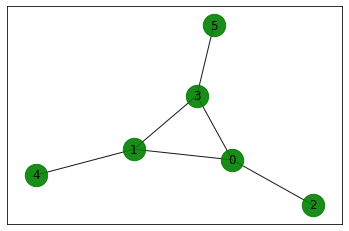

In [3]:
n = 5

V = np.arange(0, n, 1)

E = [(0, 1, 1.0), (0, 2, 1.0), (0, 3, 1.0), (1, 4, 1.0), (1, 3, 1.0), (3, 5, 1.0) ]

#Generating above graph

G = nx.Graph()
G.add_nodes_from(V)
G.add_weighted_edges_from(E)

#Plotting the Graph
nx.draw_networkx(G, node_color = 'g', node_size=500, alpha=0.9, ax = plt.axes(frameon=True), pos= nx.spring_layout(G))

In [5]:
def cuts_in_str(x, G):
    cuts = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            cuts -= 1
            
    return cuts


def compute_expectation(counts, G):
   
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        cuts = cuts_in_str(bitstring, G)
        avg += cuts * count
        sum_count += count
        
    return avg/sum_count

def QAOA_Circuit(G, theta):
    
    
    nqubits = len(G.nodes())
    p = len(theta)//2  # number of alternating unitaries
    QAOA = QuantumCircuit(nqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, nqubits):
        QAOA.h(i)
    
    for j in range(0, p):
        
        # problem unitary
        for pair in list(G.edges()):
            QAOA.rzz(2 * gamma[j], pair[0], pair[1])

        # mixer unitary
        for i in range(0, nqubits):
            QAOA.rx(2 * beta[j], i)
            
    QAOA.measure_all()        
    return QAOA

def get_expectation(G, p, shots=512):
    
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        QAOA = QAOA_Circuit(G, theta)
        counts = backend.run(QAOA, seed_simulator=10, 
                             nshots=512).result().get_counts()
        
        return compute_expectation(counts, G)
    
    return execute_circ

In [11]:
from scipy.optimize import minimize


expectation = get_expectation(G, p=100)

res = minimize(expectation, 
                      [1.0, 1.0], 
                      method='COBYLA')
res

     fun: -3.7783203125
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 31
  status: 1
 success: True
       x: array([1.20555651, 0.99054882])

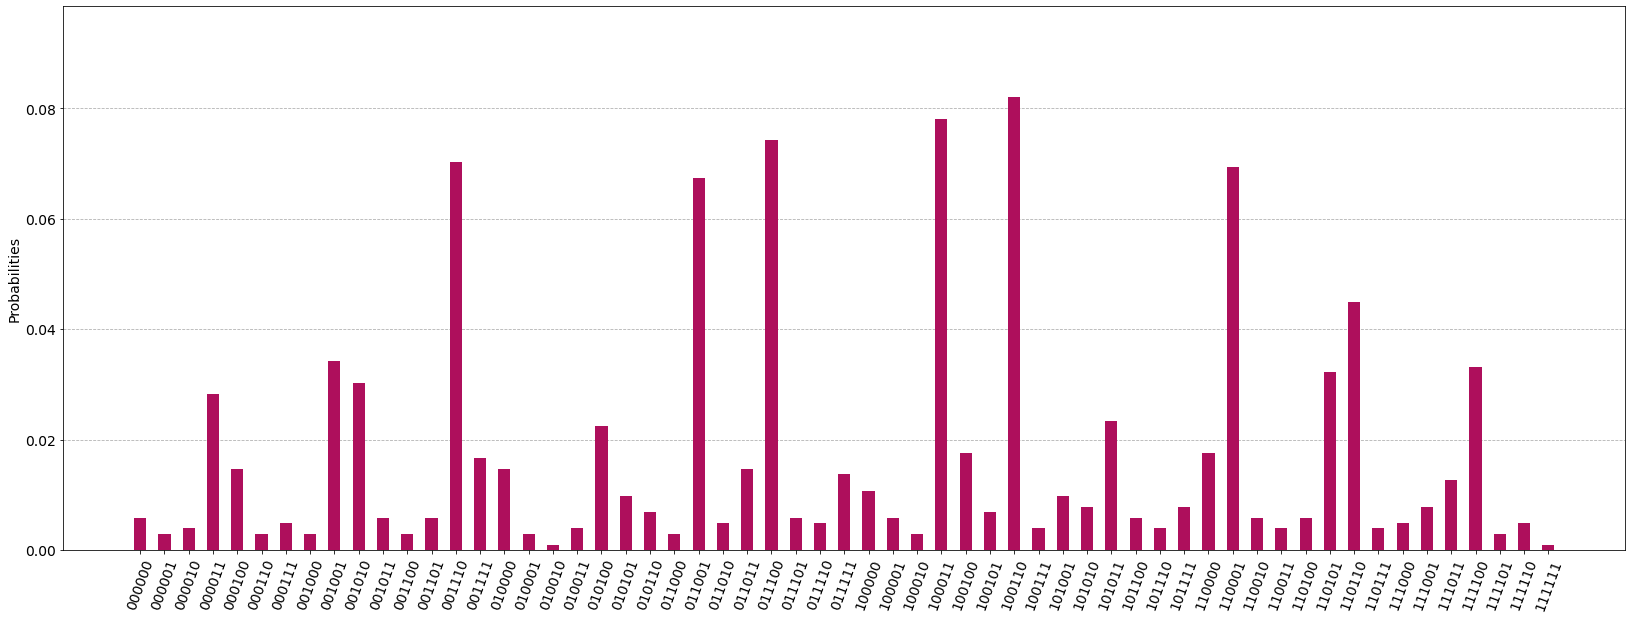

In [12]:
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('aer_simulator')
backend.shots = 512

qc_res = QAOA_Circuit(G, res.x)

counts = backend.run(qc_res, seed_simulator=10).result().get_counts()

plot_histogram(counts, figsize = (28, 10), bar_labels = False, color = '#ae0f5c')

In [13]:
def cost_function(x, G):

    E = G.edges()
    if (len(x) != len(G.nodes())):
        return np.nan
    C = 0;
    for index in E:
        e1 = index[0]
        e2 = index[1]

        w = G[e1][e2]['weight']
        C = C +w*x[e1]*(1-x[e2]) + w*x[e2]*(1-x[e1])

    return C

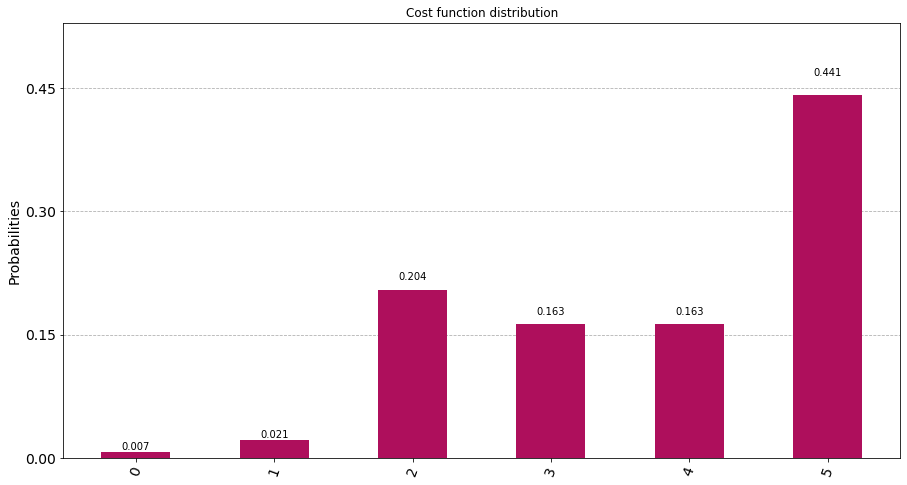

In [14]:
total_C = 0

max_C = [0,0]

hist = {}

for sample in list(counts.keys()):
    x = [int(num) for num in list(sample)]
    temp = cost_function(x,G)
    
    total_C = total_C + counts[sample]*temp
    hist[str(round(temp))] = hist.get(str(round(temp)),0) + counts[sample]
    
    if (max_C[1] < temp):
        max_C[0] = sample
        max_C[1] = temp
        
Mean_cost = total_C/backend.shots


plot_histogram(hist, figsize = (15,8), bar_labels = True,  color = '#ae0f5c', title = "Cost function distribution")
